# **Deep Learning**
## Blink detection

## 1. PRIMERA APROXIMACIÓN

Entrenar una CNN desde cero para la detección de parpadeo en una serie de imágenes.

### 1.1. Importar librerías
Lo primero que vamos a hacer es cargar las librería necesarias: Numpy. Matplotlib, TensorFlow, Keras, Google Colab, Sklearn y Pandas .


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Concatenate, ReLU

from google.colab import drive
from sklearn.model_selection import train_test_split

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3050284234270781012
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2659520893645066093
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Definimos la función generadora de las imágenes para cada ojo y etiquetas correspondientes:

In [ ]:
# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe, datagen):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                   directory = imgs_path,
                                                   target_size =(img_width, img_height),
                                                   x_col=left_eye_col,
                                                   y_col=y_col,
                                                   class_mode="binary",
                                                   seed=seed,
                                                   batch_size=batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    seed=seed,
                                                    batch_size=batch_size)
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

## 1.2. Lectura del dataset
El siguiente paso consiste en la lectura del dataset y la construcción de un dataframe con las rutas a cada una de las imágenes y sus etiquetas asociadas.

Se monta el Drive para acceder a nuestro conjunto de datos y descomprimir el fichero zip:

In [ ]:
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/RT-BENE.zip' >> /dev/null

Mounted at /content/gdrive


A contiunación, leemos los datos y construimos el dataframe:

In [ ]:
data_path = 'RT-BENE/'
imgs_path = data_path + 'images/'
labels_path = data_path + 'blinks.csv'

seed = 100

train_data = pd.read_csv(labels_path, dtype=str)

datagen = ImageDataGenerator(rescale=1./255)

aug_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             horizontal_flip=True,
                             brightness_range=[0.9,1])

En las siguientes celdas, se realizan una serie de comprobaciones relativas a balanceo de clases:

In [ ]:
print("Initially, we have the following instances per class: ")
print(train_data['blink'].value_counts())

Initially, we have the following instances per class: 
0    102793
1      4557
Name: blink, dtype: int64


Debido al desbalanceo que hay, se opta por separar el dataframe en dos, uno por cada clase, para procesarlos de manera independiente:

In [ ]:
blink = train_data.loc[train_data['blink']=='1'].reset_index()
no_blink = train_data.loc[train_data['blink']=='0'].reset_index()

In [ ]:
print(f"Blink instances: {blink.shape[0]}")
print(f"No blink instances: {no_blink.shape[0]}")

Blink instances: 4557
No blink instances: 102793


Este desbalanceo se va a intentar combatir con un sobremuestreo de la clase minortaria y la introducción de un data augmentation en el ImageDaraGenerator definido anteriormente:

In [ ]:
print("Blink instances per video: ")
print(blink['video'].value_counts())

Blink instances per video: 
0     931
2     789
11    692
8     459
10    353
13    295
14    215
3     167
7     149
4     130
1     128
5     110
9      45
16     42
15     29
12     23
Name: video, dtype: int64


In [ ]:
print("No blink instances per video: ")
print(no_blink['video'].value_counts())

No blink instances per video: 
10    16206
11    12125
0     11934
13     9291
1      8543
2      7913
8      5649
5      5245
14     5156
4      4620
16     4507
9      4165
3      3038
15     1781
7      1708
12      912
Name: video, dtype: int64


Sin embargo, antes de realizar el sobremuestreo de la clase minoritaria y para evitar que información presente en el entrenamiento aparezca en los datos de validación y test, lo primero que se va a realizar es la separación de los datos en los 3 conjuntos de entrenamiento, validación y test.

Esto separará los datos manteniendo el mismo equilibrio entre ambas clases, es decir, habrá más ejemplos de 'no parpadeo' que de 'parpadeo'. Sin embargo, como la medida que se está utilizando es el F1-Score en modo "macro" este desequilibrio no será tal.

In [ ]:
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=seed, stratify=train_data['blink'])
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=test_data['blink'])

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

batch_size = 256
img_width = 60
img_height = 36

val_generator = generator(val_data, datagen)
test_generator = generator(test_data, datagen)

In [ ]:
print(f"Total number of instances in the validation dataset: {val_data.shape[0]}")
print("\nClass balance:")
print(val_data['blink'].value_counts())

Total number of instances in the validation dataset: 16102

Class balance:
0    15419
1      683
Name: blink, dtype: int64


In [ ]:
print(f"Total number of instances in the test dataset: {test_data.shape[0]}")
print("\nClass balance:")
print(test_data['blink'].value_counts())

Total number of instances in the test dataset: 16103

Class balance:
0    15419
1      684
Name: blink, dtype: int64


In [ ]:
print("Total number of validation blinks per video:")
print(val_data[val_data['blink']=='1']['video'].value_counts())

print("\nTotal number of validation no blinks per video: ")
print(val_data[val_data['blink']=='0']['video'].value_counts())

Total number of validation blinks per video:
0     127
2     125
11    113
8      60
10     57
13     43
14     32
7      26
3      24
5      20
4      19
1      15
9       9
16      6
15      5
12      2
Name: video, dtype: int64

Total number of validation no blinks per video: 
10    2496
11    1856
0     1797
13    1390
1     1279
2     1241
8      803
5      790
14     759
4      691
16     627
9      611
3      439
15     261
7      251
12     128
Name: video, dtype: int64


Antes de definir el generador para los datos de entrenamiento, debemos hacer el sobremuestreo de la clase minoritaria.

El sobremuestreo se va a realizar de tal manera que se van a replicar las rutas de las imágenes a la clase minoritaria, y posteriormente se transformarán con el ImageDataGenerator de tal manera que los ejemplos son diferentes aunque se elija un mismo fichero de imagen.

Además, esta replicación se va a hacer por vídeo, de tal manera que tengamos el mismo número de ejemplo de parpadeo y no parpadeo también por vídeo. Esto se ha decidido ya que al revisar el dataset, se ha visto que de un vídeo a otro puede cambiar el brillo, la orientación y la persona, por lo que de esta manera se equilibran también los ejemplos para cada una de las características.


In [ ]:
def replicate_dataframe(dataframe, target_size):
    num_replications = target_size // len(dataframe) + 1
    replicated_dataframe = pd.concat([dataframe] * num_replications, ignore_index=True)
    return replicated_dataframe[:target_size]


In [ ]:
def balance_classes(new_blink, blink, no_blink):
  blink_count = blink['video'].value_counts()
  no_blink_count = no_blink['video'].value_counts()

  blink_videos = blink['video'].unique().tolist()
  no_blink_videos = no_blink['video'].unique().tolist()

  for video_id in blink_videos:
    no_blink_value = no_blink_count[video_id]

    df = replicate_dataframe(blink[blink['video']==video_id],no_blink_value-blink_count[video_id])
    new_blink = pd.concat([new_blink, df], ignore_index=True)
  
  return new_blink

In [ ]:
# Se recalculan los dataframes de 'parpadeo' y no 'parpadeo', esta vez con los datos de entrenamiento únicamente
blink = train_data[train_data['blink']=='1']
no_blink = train_data[train_data['blink']=='0']

new_blink = blink.copy()
blink_augmented = balance_classes(new_blink, blink, no_blink)
blink_augmented = blink_augmented.reset_index()

Ahora, como se puede ver, tenemos el mismo número de ejemplos de parpadeo y no parpadeo, no solamente en todo el dataset, sino también por vídeo.

In [ ]:
print("Total number of training blinks per video:")
print(blink_augmented[blink_augmented['blink']=='1']['video'].value_counts())

print("\nTotal number of training no blinks per video: ")
print(no_blink[no_blink['blink']=='0']['video'].value_counts())

Total number of training blinks per video:
10    11287
11     8508
0      8349
13     6532
1      6011
2      5419
8      3987
14     3628
5      3620
4      3255
16     3197
9      2897
3      2162
15     1250
7      1213
12      640
Name: video, dtype: int64

Total number of training no blinks per video: 
10    11287
11     8508
0      8349
13     6532
1      6011
2      5419
8      3987
14     3628
5      3620
4      3255
16     3197
9      2897
3      2162
15     1250
7      1213
12      640
Name: video, dtype: int64


Finalmente, juntamos todos los ejemplos de parpadeo y no parpadeo, confirmando nuestro dataset aumentado:

In [ ]:
train_data_aug=pd.concat([blink_augmented,no_blink], axis=0, ignore_index=True)
print(f"Total number of instances in the augmented dataset: {train_data_aug.shape[0]}")

Total number of instances in the augmented dataset: 143910


In [ ]:
print(train_data_aug['blink'].value_counts())

1    71955
0    71955
Name: blink, dtype: int64


Por limitaciones computacionales, se va a submuestrear el dataset aumentado, para que queden la mitad de instancias, per manteniendo el equilibrio entre clases:

In [ ]:
train_data_aug = train_data_aug[::2]
print(f"Total number of instances in the augmented dataset (after subsample): {train_data_aug.shape[0]}")
print("\nClass balance:")
print(train_data_aug['blink'].value_counts())

Total number of instances in the augmented dataset (after subsample): 71955

Class balance:
1    35978
0    35977
Name: blink, dtype: int64


In [ ]:
train_data_aug[:10]

,index,blink_id,left_eye,right_eye,video,blink
0,0.0,613,0_left_000622_rgb.png,0_right_000622_rgb.png,0,1
2,2.0,26639,2_left_009477_rgb.png,2_right_009477_rgb.png,2,1
4,4.0,29268,2_left_013771_rgb.png,2_right_013771_rgb.png,2,1
6,6.0,53564,9_left_003022_rgb.png,9_right_003022_rgb.png,9,1
8,8.0,27200,2_left_010517_rgb.png,2_right_010517_rgb.png,2,1
10,10.0,7765,0_left_011010_rgb.png,0_right_011010_rgb.png,0,1
12,12.0,49743,8_left_012223_rgb.png,8_right_012223_rgb.png,8,1
14,14.0,3075,0_left_003640_rgb.png,0_right_003640_rgb.png,0,1
16,16.0,82788,11_left_014971_rgb.png,11_right_014971_rgb.png,11,1
18,18.0,37881,4_left_007642_rgb.png,4_right_007642_rgb.png,4,1


Y para que no queden primero los valores de una clase seguidos de los de otra, se van a mezclar los ejemplos como se hace por defecto en la función train_test_split:

In [ ]:
train_data_aug = train_data_aug.sample(frac=1, replace=False, random_state=seed)
print(f"Total number of instances in the augmented dataset (after subsample): {train_data_aug.shape[0]}")
print("\nClass balance:")
print(train_data_aug['blink'].value_counts())

Total number of instances in the augmented dataset (after subsample): 71955

Class balance:
1    35978
0    35977
Name: blink, dtype: int64


In [ ]:
train_data_aug[:10]

,index,blink_id,left_eye,right_eye,video,blink
60162,60162.0,100758,14_left_006072_rgb.png,14_right_006072_rgb.png,14,1
34888,34888.0,15039,1_left_002406_rgb.png,1_right_002406_rgb.png,1,1
49282,49282.0,72828,11_left_000554_rgb.png,11_right_000554_rgb.png,11,1
90546,NaN,86301,13_left_000268_rgb.png,13_right_000268_rgb.png,13,0
104646,NaN,86574,13_left_000541_rgb.png,13_right_000541_rgb.png,13,0
32174,32174.0,92584,13_left_013100_rgb.png,13_right_013100_rgb.png,13,1
100278,NaN,17072,1_left_005013_rgb.png,1_right_005013_rgb.png,1,0
104336,NaN,79928,11_left_011311_rgb.png,11_right_011311_rgb.png,11,0
78860,NaN,28590,2_left_012628_rgb.png,2_right_012628_rgb.png,2,0
55216,55216.0,34174,4_left_001292_rgb.png,4_right_001292_rgb.png,4,1


Finalmente, creamos el generador de los datos de entrenamiento utilizando *data augmentation*:

In [ ]:
train_generator = generator(train_data_aug, aug_datagen)

## 1.3. Entrenamiento del modelo

A continuación, se define y realiza el entrenamiento del modelo elegido (CNN). 

En primer lugar, se visualizan algunas de las imágenes de entrenamiento junto con sus etiquetas:


Found 71955 validated image filenames belonging to 2 classes.
Found 71955 validated image filenames belonging to 2 classes.


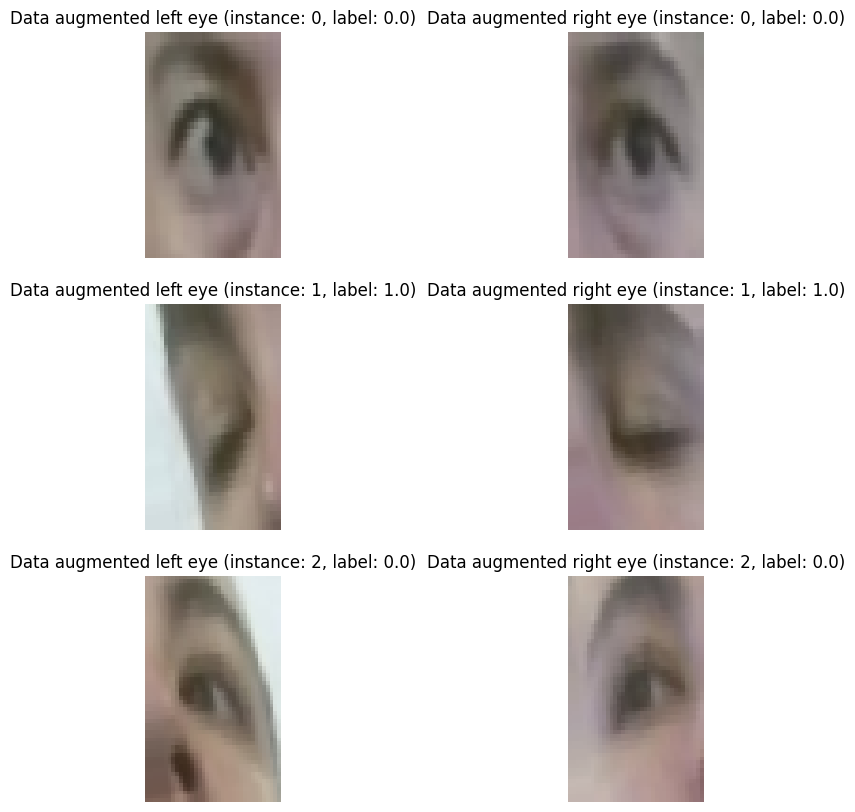

In [ ]:
aug_iter = generator(train_data_aug, aug_datagen)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

for i in range(3):
  eye = next(aug_iter)
  left_eye_image = eye[0][0][i]
  right_eye_image = eye[0][1][i]

  ax[i,0].imshow(right_eye_image)
  ax[i,1].imshow(left_eye_image)
  ax[i,0].axis('off')
  ax[i,1].axis('off')

  ax[i,0].set_title(f'Data augmented left eye (instance: {i}, label: {eye[1][i]})')
  ax[i,1].set_title(f'Data augmented right eye (instance: {i}, label: {eye[1][i]})')

El entrenamiento de la red se va a realizar utilizando el F1-Score como medida de evaluación. para ello, es necesario instalar el módulo 'tfa' de los 'tensorflow_addons'

In [ ]:
!pip3 install --upgrade pip
!pip3 install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.5/591.5 kB 38.7 MB/s eta 0:00:00


Definimos el modelo de la red neuronal convolucional:
- Dos capas de entrada (ojo izquierdo y derecho)
- Capa de concatenación para juntar en una sola las dos imágenes. La concatenación se hace en la primera dimensión, es decir, se concatenan horizontalmente.
- Dos capas convolucionales (16@3x3 y 32@3x3) con una regularización Dropout al 50%.
- Una capa plana para juntar todas las careacterísticas latentes extraídas por la red
- Una capa densa, que procesará de menra conjunta las características latentes.
- Una capa de salida con una única neurona y activación sigmoide (caso típico de clasificación binaria sin utilizar one-hot encoding).

Además, se van a inicializar los pesos de cada capa con una normal de media 0 y desviación típica igual a 1, con el objetivo de ayudar a la generalización de la red.

In [ ]:
#kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.)

In [ ]:
import tensorflow_addons as tfa

input_shape = (60, 36, 3)
# Declaramos dos capas de Input
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_layer= Concatenate(name='concat', axis=1)([input_1, input_2])
'''
conv_1 = Conv2D(32, 3, name='conv1', padding='same', input_shape=(img_width,img_height,3))(concat_layer)
batchNorm_1 = BatchNormalization()(conv_1)
relu_1 = ReLU()(batchNorm_1)
dr_1 = Dropout(0.5)(relu_1)
max_1 = MaxPooling2D(name='max1', pool_size=2, strides=2)(dr_1)

conv_2 = Conv2D(64, 3, name='conv2', padding='same')(max_1)
batchNorm_2 = BatchNormalization()(conv_2)
relu_2 = ReLU()(batchNorm_2)
dr_2 = Dropout(0.5)(relu_2)
max_2 = MaxPooling2D(name='max2', pool_size=3, strides=3)(dr_2)
'''

conv_1 = Conv2D(16, 3, name='conv1', activation='relu', 
                padding='same', 
                input_shape=(img_width,img_height,3))(concat_layer)
dr_1 = Dropout(0.5)(conv_1)
max_1 = MaxPooling2D(name='max1', pool_size=2, strides=2)(dr_1)

conv_2 = Conv2D(32, 3, name='conv2', activation='relu', 
                padding='same')(max_1)
dr_2 = Dropout(0.5)(conv_2)
max_2 = MaxPooling2D(name='max2', pool_size=3, strides=3)(dr_2)


flat_layer = Flatten(name='flat')(max_2)

dense_1 = Dense(64, name='dense1', activation='relu')(flat_layer)
predictions = Dense(1, name='output', activation='sigmoid')(dense_1)

# Creamos el modelo final y lo compilamos
model = Model(inputs=[input_1, input_2], outputs=[predictions], name='blink_detector')
# Compilamos el modelo
model.compile(loss='binary_crossentropy',                # función de pérdida para problemas de clasificación binaria
              optimizer=optimizers.Adam(learning_rate=1e-3),  # optimizador Adam
              metrics=tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'))

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
model.summary()

Model: "blink_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 120, 36, 3)   0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 36, 16)  448         ['concat[0][0]']    

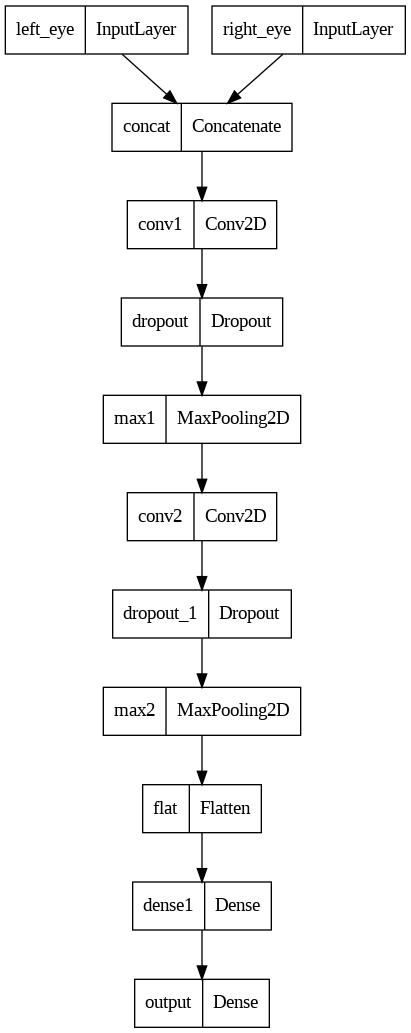

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

In [ ]:
## Función para mostrar la evolución de la pérdida durante el entrenamiento
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('binary_crossentropy')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])

Como medida para evitar el overfitting, se aplica un early stopping al entrenamiento de la red. Este early stopping va a tomar como medida de referencia la pérdida en valdiación, y en cuanto detecte que esta no se mejora durante 5 épocas seguidas, parará el entrenamiento.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

A continuación, se entrena el modelo y se grafica su evolución:

In [ ]:
# Entrenamos el modelo con los datos preparados en el punto 2
history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=val_generator,
                    validation_steps=len(val_data)/batch_size,
                    callbacks=[early_stopping])

Found 71955 validated image filenames belonging to 2 classes.
Found 71955 validated image filenames belonging to 2 classes.
Epoch 1/25
294/293 [==============================] - ETA: 0s - loss: 0.5510 - f1_score: 0.6994Found 16102 validated image filenames belonging to 2 classes.
Found 16102 validated image filenames belonging to 2 classes.
293/293 [==============================] - 270s 872ms/step - loss: 0.5510 - f1_score: 0.6994 - val_loss: 0.4135 - val_f1_score: 0.3533
Epoch 2/25
293/293 [==============================] - 242s 829ms/step - loss: 0.3049 - f1_score: 0.8747 - val_loss: 0.3189 - val_f1_score: 0.4834
Epoch 3/25
293/293 [==============================] - 243s 832ms/step - loss: 0.2533 - f1_score: 0.8975 - val_loss: 0.2630 - val_f1_score: 0.5842
Epoch 4/25
293/293 [==============================] - 244s 833ms/step - loss: 0.2246 - f1_score: 0.9114 - val_loss: 0.2623 - val_f1_score: 0.5084
Epoch 5/25
293/293 [==============================] - 239s 816ms/step - loss: 0.2000

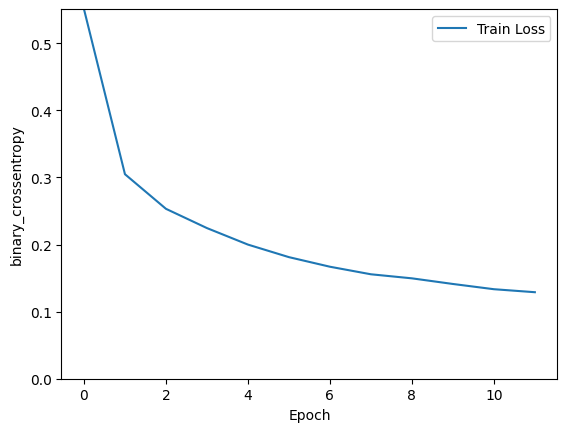

In [ ]:
plot_history(history)

Finalmente, se evalúa el modelo entrenado:

In [ ]:
# Por último, podemos evaluar el modelo en el conjunto de test
test_loss, test_f1 = model.evaluate(test_generator,
                                     batch_size=batch_size,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test F1-Score: {test_f1}")

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
62/62 [==============================] - 16s 265ms/step - loss: 0.1599 - f1_score: 0.6894
Test loss: 0.15993034839630127
Test F1-Score: 0.6893523931503296




---



## 2. SEGUNDA APROXIMACIÓN - TRANSFER LEARNING

En esta ocasión, con los mismos datos que antes, se va utilizar una red pre-entrenada, que se adaptará con una capa de entrada otras a la salida.

Solamente se entrenarán estas capas de salida durante la fase de entrenamiento, quedándose los pesos de la red original sin modificar.

In [ ]:
# Cargamos el modelo InceptionV3 pre-entrenado con ImageNet
base_model = applications.resnet.ResNet152(weights='imagenet', include_top=False, input_shape=(img_width*2,img_height,3))

# En el modelo base, hacemos que todas sus capas sean no entrenables
for layer in base_model.layers:
    layer.trainable = False

# Añadimos las dos capas de entrada y la de concatenación, para adapatarlas al modelo base
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_transfer = Concatenate(name='concat', axis=1)([input_1, input_2])
new_base = base_model(concat_transfer)

# Añadimos nuevas capas al final para adaptar el modelo a nuestro problema
x = GlobalAveragePooling2D()(new_base) # Para eliminar la necesidad de una capa densa muy grande
x = Dense(1024, activation='relu')(x)
predictions_transfer = Dense(1, activation='sigmoid')(x) 

# Creamos el modelo final y lo compilamos
model_transfer = Model(inputs=[input_1, input_2], outputs=[predictions_transfer], name='blink_detector_transfer')

model_transfer.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'))

234698864/234698864 [==============================] - 11s 0us/step


In [ ]:
model_transfer.summary()

Model: "blink_detector_transfer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 120, 36, 3)   0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 resnet152 (Functional)         (None, 4, 2, 2048)   58370944    ['concat[0]

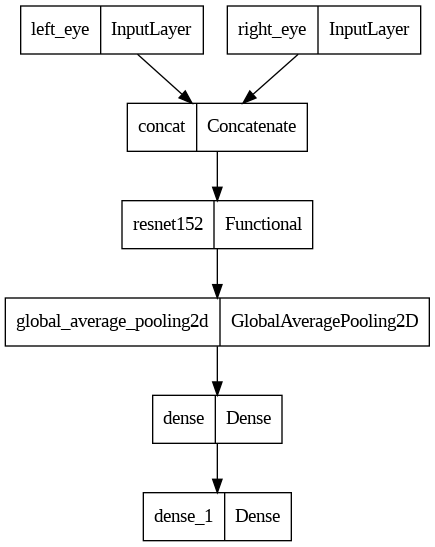

In [ ]:
keras.utils.plot_model(model_transfer, to_file='model_transfer.png')

In [ ]:
# Entrenamos el nuevo modelo
history_transfer = model_transfer.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=val_generator,
                    validation_steps=len(val_data)/batch_size,
                    callbacks=[early_stopping])

Epoch 1/25
293/293 [==============================] - 279s 910ms/step - loss: 0.7126 - f1_score: 0.5601 - accuracy: 0.5523 - val_loss: 0.6177 - val_f1_score: 0.1358 - val_accuracy: 0.6641
Epoch 2/25
293/293 [==============================] - 266s 910ms/step - loss: 0.6653 - f1_score: 0.5998 - accuracy: 0.5924 - val_loss: 0.3358 - val_f1_score: 0.0000e+00 - val_accuracy: 0.9585
Epoch 3/25
293/293 [==============================] - 266s 908ms/step - loss: 0.6339 - f1_score: 0.6479 - accuracy: 0.6382 - val_loss: 0.4075 - val_f1_score: 0.3140 - val_accuracy: 0.9278
Epoch 4/25
293/293 [==============================] - 284s 971ms/step - loss: 0.6227 - f1_score: 0.6525 - accuracy: 0.6468 - val_loss: 0.4048 - val_f1_score: 0.3299 - val_accuracy: 0.9142
Epoch 5/25
293/293 [==============================] - 267s 913ms/step - loss: 0.6070 - f1_score: 0.6762 - accuracy: 0.6682 - val_loss: 0.3350 - val_f1_score: 0.3048 - val_accuracy: 0.9380
Epoch 6/25
293/293 [==============================] - 28

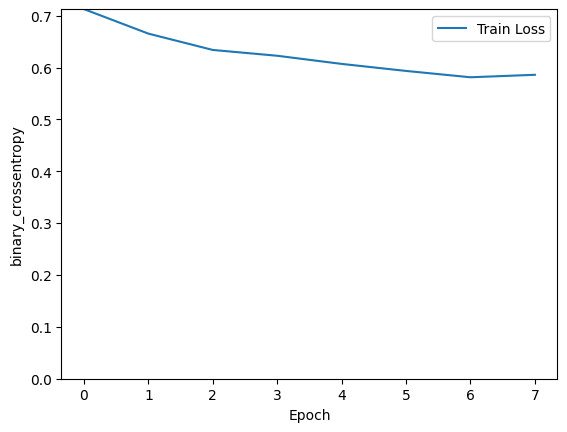

In [ ]:
# Mostramos la evolución de su entrenamiento
plot_history(history_transfer)

In [ ]:
# Y finalmente, evaluamos el modelo en el conjunto de test
print("\n")
test_loss_transfer, test_f1_transfer, test_accuracy_transfer = model_transfer.evaluate(test_generator,
                                                                                       steps=len(test_data)/batch_size,
                                                                                       verbose=1)
print(f"Test loss (transfer learning): {test_loss_transfer}")
print(f"Test F1-Score (transfer learning): {test_f1_transfer}")



62/62 [==============================] - 21s 340ms/step - loss: 0.3361 - f1_score: 0.2973 - accuracy: 0.9363
Test loss (transfer learning): 0.3361402750015259
Test F1-Score (transfer learning): 0.29726025462150574
Test accuracy (transfer learning): 0.936285138130188


In [ ]:
print(history.history)

{'loss': [0.5509629845619202, 0.30486196279525757, 0.25328001379966736, 0.22455713152885437, 0.1999552845954895, 0.18123599886894226, 0.16695261001586914, 0.15569022297859192, 0.14964725077152252, 0.1412477046251297, 0.1334383487701416, 0.12895768880844116], 'f1_score': [0.6994158029556274, 0.8746764659881592, 0.8974895477294922, 0.9113739728927612, 0.9221755266189575, 0.9282501339912415, 0.9340067505836487, 0.9391638040542603, 0.9423850774765015, 0.9456984996795654, 0.9490808248519897, 0.9507115483283997], 'val_loss': [0.4135276675224304, 0.3188788592815399, 0.26301634311676025, 0.2622941732406616, 0.22287055850028992, 0.2359704077243805, 0.2099066823720932, 0.2284097820520401, 0.15522754192352295, 0.1745302677154541, 0.18518377840518951, 0.19555698335170746], 'val_f1_score': [0.3532630205154419, 0.48343852162361145, 0.5841537714004517, 0.5084214806556702, 0.6515524983406067, 0.5530822277069092, 0.5925925970077515, 0.5215685963630676, 0.7220097780227661, 0.6470880508422852, 0.59803038

In [ ]:
print()